# Graph layout

- using Fire optimization alogorithm
- Electric-spring force model
- plus a three point bending force

In [7]:
using(BenchmarkTools)

In [104]:
import(Plots)

In [59]:
import(JSON)

In [105]:
# Graph the graph
function graphplot(graph, chains)
    fig = Plots.plot(legend=false, aspect_ratio=:equal)
    #scatter!(coords[:, 1], coords[:, 2], linewidth=2)
    for chain in chains
        chain_xy = map(x -> graph[x].position, chain);
        filter!(xy -> ~isnothing(xy), chain_xy)
        if length(chain_xy) > 0
            x = getindex.(chain_xy, 1)
            y = getindex.(chain_xy, 2)
            Plots.plot!(x, y, linewidth=3)
            end;
        #println(coords[idx, 1])
        end;
    fig
    end;

In [217]:
mutable struct Node
    neighbors
    position::Union{Nothing, Tuple{Float64, Float64}}
    velocity::Union{Nothing, Tuple{Float64, Float64}}
    force::Union{Nothing, Tuple{Float64, Float64}}
    energy::Float64
    previous_force::Union{Nothing, Tuple{Float64, Float64}}
    end;

Node() = Node([], nothing, nothing, nothing, nothing, nothing)

ErrorException: invalid redefinition of constant Node

In [129]:
# init graph data structure
function create_graph(chains)
    graph = Dict()
    for chain in chains
        node = get!(graph, chain[1], Node())
        push!(node.neighbors, (nothing, chain[2]))

        for k in 2:length(chain)-1
            node = get!(graph, chain[k], Node())
            push!(node.neighbors, (chain[k-1], chain[k+1]))
            end;

        node = get!(graph, chain[end], Node())
        push!(node.neighbors, (chain[end-1], nothing))
        end;
    
    return graph
    end;

function place_on_circle!(graph, node_ids=[])    
    # init coordinates (on a circle)
    if length(node_ids)==0
        node_ids = keys(graph)
        end;
    N = length(node_ids)
    radius = N/(2*pi)
    delta_theta = 2*pi/N
    for (k, node_id) in enumerate(node_ids)
        node = graph[node_id]
        theta = k*delta_theta
        node.position = [radius*cos(theta), radius*sin(theta)]
        #node.previous_position = node.position
        node.velocity = (0.0, 0.0)
        #node.previous_velocity = (0.0, 0.0)
        end;

    end;

In [182]:
# Velocity Verlet
# http://students.iitk.ac.in/projects/wiki/lib/exe/fetch.php?media=2014as:verlet.pdf
function velocity_verlet!(graph, dt)
    dt2_2 = dt^2 / 2
    
    #nodes = filter(n -> ~isnothing(n.position), collect(values(graph)))
    nodes = values(graph)
    # Positions
    for node in nodes
        dX = (dt2_2).*node.force
        #if norm(dX) > 7.0
        #    dX = 7 .* dX ./ norm(dX)
        #    end;
        node.position = node.position .+ dX
        #node.previous_force = node.force
        end;
    
    # Forces
    reset_forces!(graph)
    all_attractive_forces!(graph)
    all_repulsive_forces!(graph)
    
    # Velocities
    for node in nodes
        node.velocity = node.velocity .+ (node.force .+ node.previous_force).*(0.5dt)    
        end;
    
    end;

In [176]:
dot(a, b) = sum(a .* b);
norm(a) = sqrt(dot(a, a));
unit_vector(a) = a./norm(a);

In [177]:
mutable struct Fire
    N_min::Int64
    f_inc::Float64
    f_dec::Float64
    alpha_start::Float64
    f_alpha::Float64
    dt_max::Float64
    # variable
    dt::Float64
    N::Int64
    alpha::Float64
end

Fire() = Fire(
    5, # N_min
    1.1, # f_inc
    0.5, # f_dec
    0.1, # alpha_start 
    0.99,# f_alpha 
    0.5, # dt_max 
    # variable
    .1,  # dt 
    0,   # N 
    0.1 # alpha = alpha_start
)

Fire

In [173]:
Fire()

Fire(5, 1.1, 0.5, 0.1, 0.99, 0.5, 0.1, 0, 0.1)

In [218]:
# Fire minimization
# Bitzek, Erik, et al. "Structural relaxation made simple."
# Physical review letters 97.17 (2006): 170201.

function step!(graph, fire)
    
    # loop
    velocity_verlet!(graph, fire.dt)

    #nodes = filter(n -> ~isnothing(n.position), collect(values(graph)))
    nodes = values(graph)
    P = sum( dot(node.force, node.velocity) for node in nodes )

    for node in nodes
        hat_F = unit_vector(node.force)
        v = node.velocity
        node.velocity = (1 - fire.alpha).*v .+ (fire.alpha * norm(v)).*hat_F  
        end;

    if P > 0 && fire.N > fire.N_min
        fire.dt = min(fire.f_inc*fire.dt, fire.dt_max)
        fire.alpha = fire.alpha * fire.f_alpha
        fire.N = 0
    elseif P > 0
        fire.N += 1
        end;
    
    if P <= 0
        fire.dt = fire.f_dec * fire.dt
        fire.alpha = fire.alpha_start
        foreach(node -> node.velocity = (0.0, 0.0), nodes)
        fire.N = 0
        end;

    end;

In [219]:
# test graph
chains = [["A", "B", "C", "D", "E"],
          ["R", "E", "T", "ER", "erz", "ZE"],
          ["C", "re", "eze"]]

graph = create_graph(chains)

place_on_circle!(graph)
reset_forces!(graph)

In [263]:
# ====================
# Load graph from Json
files = filter(x -> endswith(x, "_chains.json"), readdir("./data/"))

println(files)

file_name = files[1]
path = string("./data/", file_name)
data = read(path, String)
d = []
chains = JSON.parse(data, dicttype=Array{Array{String}});
sort!(chains, by=x->length(x), rev=true)
println("number of chains: ", length(chains))

graph = create_graph(chains);
place_on_circle!(graph)
reset_forces!(graph)

["103665013_22_chains.json", "118282182_148_chains.json", "139009531_11072_chains.json", "183073932_167_chains.json"]
number of chains: 4


In [280]:
fire = Fire()
for k in 1:700
    step!(graph, fire)
    end;

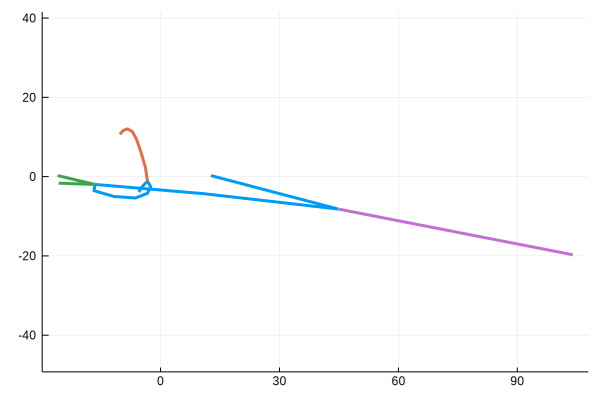

In [281]:
graphplot(graph, chains)

In [254]:
const coeff = 5.0
function three_body_force(u, v)
    #  points a, b, c
    #  u = b - a
    #  v = c - b
    #  F->a = -dE/da = dE/du
    #  F->c = -dE/dc = -dE/dv
    #  F->b = -F->a - F->c = -dE/du + dE/dv
    # 
    #  E = -cos( (a, b, c) )

    x1, y1 = u
    x2, y2 = v
    norm2_u = x1^2 + y1^2
    norm2_v = x2^2 + y2^2
    cross = x1*y2 - x2*y1

    cross_nunv = coeff * cross / sqrt( norm2_u*norm2_v )
    s3 = cross_nunv / norm2_u
    s4 = cross_nunv / norm2_v
    
    dEdu = (s3*y1, -s3*x1)
    dEdv = (-s4*y2, s4*x2)
    return dEdu, .-dEdu .+ dEdv, .-dEdv
    end;

# Spring (+2 power)
# F = (-x, -y)
# u = b - a
# F->b
spring_force(u) = -2 .* u;

const EPSILON = 1e-5
function repulsive_force_Coulomb(u)
    d4 = (sum(u.^2) + EPSILON)^2
    return 2/d4.*u
    end;

In [144]:
function reset_forces!(graph)
    for node in values(graph)
        if ~isnothing(node.position)
            node.previous_force = node.force;
            node.force = (0.0, 0.0);
            end;
        end;
    end;

In [117]:
repulsive_force_Coulomb((1., 1.))

(0.4999950000374997, 0.4999950000374997)

In [141]:
function all_attractive_forces!(graph)
    # Compute all forces
    reset_forces!(graph)

    # Link forces
    for node in values(graph)
        if isnothing(node.position)
            continue
            end;

        for (left_name, right_name) in node.neighbors
            if !isnothing(left_name) && !isnothing(graph[left_name].position)
                left = graph[left_name]
                # Compute pair force
                u = node.position .- left.position
                F = spring_force(u)
                left.force = left.force .- F
                node.force = node.force .+ F

                if !isnothing(right_name) && !isnothing(graph[right_name].position)
                    right = graph[right_name]
                    v = right.position .- node.position
                    # Compute three body force
                    Fa, Fb, Fc = three_body_force(u, v)
                    left.force = left.force .+ Fa
                    node.force = node.force .+ Fb
                    right.force = right.force .+ Fc
                    end;

                end;
            
            end;
        end;

    # Repulsive forces
    for (k, node_a) in enumerate(values(graph))
        if isnothing(node_a.position)
            continue
            end;
        for node_b in Iterators.take(values(graph), k-1)
             if ~isnothing(node_b.position)
                u = node_b.position .- node_a.position
                Fb = repulsive_force_Coulomb(u)
                node_a.force = node_a.force .- Fb
                node_b.force = node_b.force .+ Fb
                end;
            end;
        end;
    end;

function all_repulsive_forces!(graph)
    # Repulsive forces
    for (k, node_a) in enumerate(values(graph))
        if isnothing(node_a.position)
            continue
            end;
        for node_b in Iterators.take(values(graph), k-1)
             if ~isnothing(node_b.position)
                u = node_b.position .- node_a.position
                Fb = repulsive_force_Coulomb(u)
                node_a.force = node_a.force .- Fb
                node_b.force = node_b.force .+ Fb
                end;
            end;
        end;
    end;